### Interview Project for DeepHealth

Jim DiLorenzo

#### Project Description
The main goal of the problem is to test how you think through solving the problem. It should also naturally show your coding skills and how you communicate results. The problem should take less than 4 hours. I have provided the prompt below with the attached dataset. Please provide your answer as a Python Jupyter notebook by next Wednesday. Good luck!

 

##### Prompt

A screening mammogram normally consists of two views of each breast (CC and MLO views). I’ve attached a csv that contains example outputs from an ML model on each view separately. What I would like you to explore is combining the predictions from each view to come up with a breast level score. It’s an open-ended problem and we’re not looking for a final optimal solution, but more of the process of thinking through the problem. The metric you can use for evaluation is AUROC grouped by “study_num” and laterality (L/R).

### Section 1: Exploratory Data Analysis

In [1]:
# dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
pd.options.display.max_columns = None

# custom code file of convenient python EDA functions
import eda_utils

In [2]:
# read data
df_all_input = pd.read_csv("example_outputs.csv")

In [3]:
df_all = df_all_input.copy()
df_all.head()

,Unnamed: 0,study_num,view,y,yhat
0,0,8,LCC,0,0.000857
1,1,8,RMLO,1,0.542956
2,2,8,RCC,1,0.525933
3,3,10,RMLO,1,0.354297
4,4,10,LCC,0,0.000446


In [4]:
df_all.describe()

,Unnamed: 0,study_num,y,yhat
count,5914.000000,5914.000000,5914.000000,5914.000000
mean,2956.500000,7248.516064,0.235374,0.153561
std,1707.369077,4264.464809,0.424268,0.229188
min,0.000000,8.000000,0.000000,0.000168
25%,1478.250000,3486.500000,0.000000,0.000964
50%,2956.500000,8385.000000,0.000000,0.002955
75%,4434.750000,11077.750000,0.000000,0.279555
max,5913.000000,13987.000000,1.000000,0.847084


#### Notes
* Given the problem description I know that view can be broken out as laterality (L/R) and view type (CC/MLO)
* Since the data set size is small, I am not going to downscale the dtypes from int32/float64 to int32/float32

In [5]:
df_all['view'].value_counts()

RCC     1571
LCC     1554
RMLO    1523
LMLO    1266
Name: view, dtype: int64

In [6]:
# not needed based on value counts but I like to be careful with strings
df_all['view'] = df_all['view'].astype(str).str.upper()
df_all['view'] = df_all['view'].astype(str).str.strip()

In [7]:
# making the new features
df_all['laterality'] = df_all['view'].str[0]
df_all['view_type'] = df_all['view'].str[1:]

# checking that laterality and view type are the expected outputs (L/R) and (CC/MLO)
print(df_all['laterality'].value_counts())
print(df_all['view_type'].value_counts())

R    3094
L    2820
Name: laterality, dtype: int64
CC     3125
MLO    2789
Name: view_type, dtype: int64


In [8]:
# renaming the index column
df_all.rename(columns={"Unnamed: 0": "row_num"},inplace=True)

In [9]:
df_all.head()

,row_num,study_num,view,y,yhat,laterality,view_type
0,0,8,LCC,0,0.000857,L,CC
1,1,8,RMLO,1,0.542956,R,MLO
2,2,8,RCC,1,0.525933,R,CC
3,3,10,RMLO,1,0.354297,R,MLO
4,4,10,LCC,0,0.000446,L,CC


In [10]:
# I'm curious if grouping by the study_num and L/R indicates something about the target
# ie if all
df_temp = df_all[['study_num', 'y', 'laterality']]
df_temp = df_temp.groupby(['study_num','laterality']).mean()
df_temp = df_temp.reset_index()
df_temp.head()

,study_num,laterality,y
0,8,L,0.0
1,8,R,1.0
2,10,L,0.0
3,10,R,1.0
4,12,L,1.0


In [11]:
# I expect 0 and 1 if all R's for each study_num and all L's for each study_num have the same values
df_temp['y'].value_counts()

0.0    2393
1.0     709
Name: y, dtype: int64

#### Notes:
* I believe this means that in the data set, each study_num and laterality has the same target variable. Ie RCC and RMLO (and LCC and LMLO) will have the same target for each study_num.
* This could indicate that each study_num is a specific patient.
* I'm going to create some features based on number of R and L tests for each study_num. If each study_num is patient specific, the number of tests (and the fact that only one side is being tested) could indicate something.

In [12]:
# creating features for count of number of tests done by study level by laterality
df_all_backup = df_all.copy() # storing here temporarily since I'm not the best with groupby and merges
df_temp = df_all.groupby(['study_num','laterality'])['row_num'].count().reset_index(name="lat_sn_count")

# merge counts in
df_all_backup = df_all_backup.merge(df_temp, how="inner",on=['study_num','laterality'])
df_all_backup.head()

,row_num,study_num,view,y,yhat,laterality,view_type,lat_sn_count
0,0,8,LCC,0,0.000857,L,CC,1
1,1,8,RMLO,1,0.542956,R,MLO,2
2,2,8,RCC,1,0.525933,R,CC,2
3,3,10,RMLO,1,0.354297,R,MLO,2
4,5,10,RCC,1,0.070244,R,CC,2


In [13]:
# creating features for count of types of tests by study_num
df_temp = df_all.groupby(['study_num','view_type'])['row_num'].count().reset_index(name="view_type_sn_count")

# merge counts in
df_all_backup = df_all_backup.merge(df_temp, how="inner",on=['study_num','view_type'])
df_all_backup.head()

,row_num,study_num,view,y,yhat,laterality,view_type,lat_sn_count,view_type_sn_count
0,0,8,LCC,0,0.000857,L,CC,1,2
1,2,8,RCC,1,0.525933,R,CC,2,2
2,1,8,RMLO,1,0.542956,R,MLO,2,1
3,3,10,RMLO,1,0.354297,R,MLO,2,1
4,5,10,RCC,1,0.070244,R,CC,2,2


In [14]:
# going back to df_all
df_all = df_all_backup.copy()
df_all.head()

,row_num,study_num,view,y,yhat,laterality,view_type,lat_sn_count,view_type_sn_count
0,0,8,LCC,0,0.000857,L,CC,1,2
1,2,8,RCC,1,0.525933,R,CC,2,2
2,1,8,RMLO,1,0.542956,R,MLO,2,1
3,3,10,RMLO,1,0.354297,R,MLO,2,1
4,5,10,RCC,1,0.070244,R,CC,2,2


In [15]:
# starting my custom EDA
eda_utils.describe_data_frame(df_all,-1)

Number of rows: 5914
Number of columns: 9
Number of numeric columns: 6
Number of columns with a NA value: 0


#### Notes
* small data set (both number of rows and columns)
* no NA values

#### Custom EDA
Over the years I have made custom file called eda_utils.py which has many of the EDA techniques I often use on problems. I call some basic functions through that script. Much of the output from those functions can be ignored or skimmed through quickly. The script has some safety checks that I like to rely on and some basic EDA.

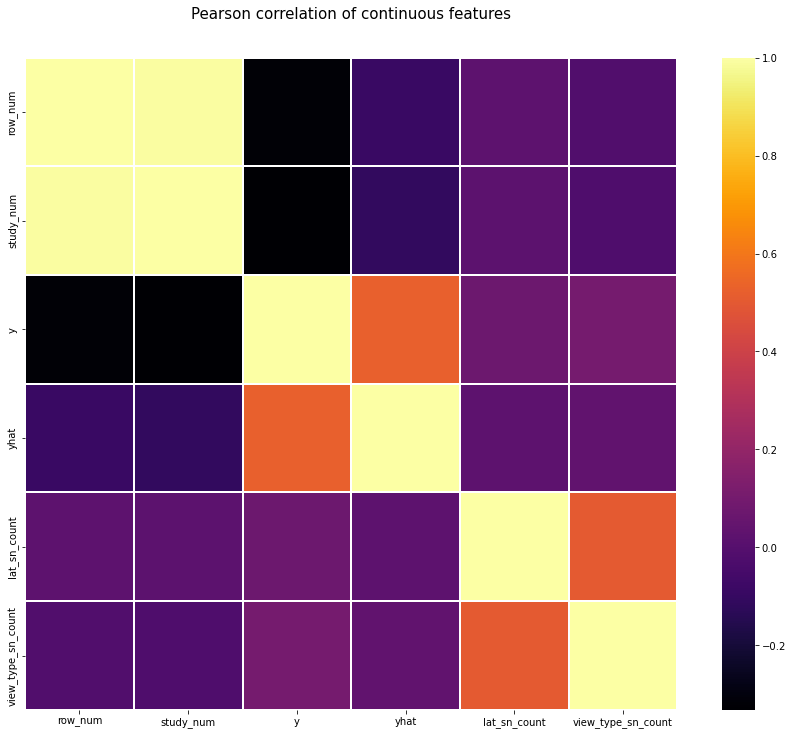

In [16]:
# display correlation between features
eda_utils.display_corr(df_all)

#### Notes
* Data given to us in study_num from smallest to largest
* As hoped for yhat correlates with y but not at a strong level

Target Column Counts and Distribution: 
0    4522
1    1392
Name: y, dtype: int64
0    76.5
1    23.5
Name: y, dtype: float64

row_num -- Feature 
count    5914.0
mean     2956.0
std      1707.0
min         0.0
25%      1478.0
50%      2956.0
75%      4435.0
max      5913.0
Name: row_num, dtype: float64


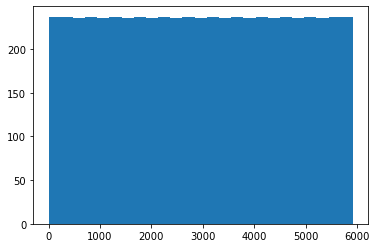

 | is numeric | 5914 unique values 

study_num -- Feature 
count     5914.0
mean      7249.0
std       4264.0
min          8.0
25%       3486.0
50%       8385.0
75%      11078.0
max      13987.0
Name: study_num, dtype: float64


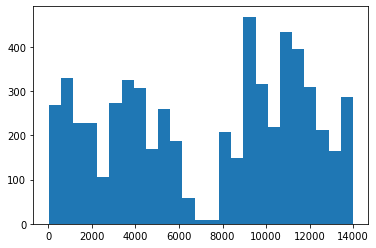

 | is numeric | 1678 unique values 

view -- Feature 
 | is not numeric | 4 unique values  | consider one-hot?
target percentages:  0    76.5
1    23.5
Name: y, dtype: float64
        view
view y      
LCC  0  76.3
     1  23.7
LMLO 0  75.4
     1  24.6
RCC  0  77.3
     1  22.7
RMLO 0  76.6
     1  23.4


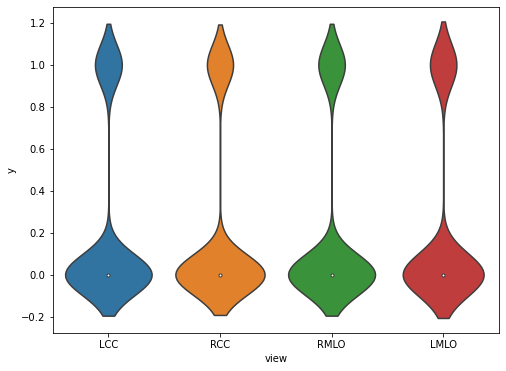


y -- Feature 
count    5914.00
mean        0.24
std         0.42
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: y, dtype: float64


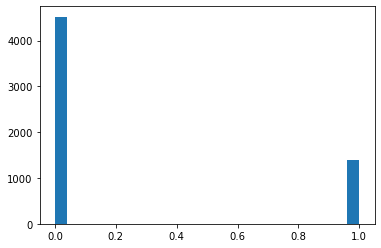

 | is numeric | 2 unique values  | consider one-hot? (ordinal?) 
target percentages:  0    76.5
1    23.5
Name: y, dtype: float64
         y
y y       
0 0  100.0
1 1  100.0


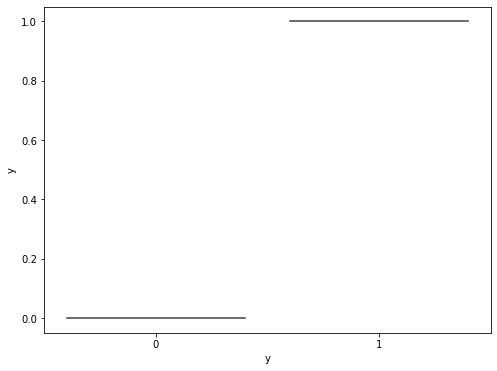


yhat -- Feature 
count    5914.00
mean        0.15
std         0.23
min         0.00
25%         0.00
50%         0.00
75%         0.28
max         0.85
Name: yhat, dtype: float64


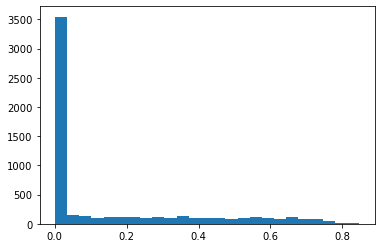

 | is numeric | 5910 unique values 

laterality -- Feature 
 | is not numeric | 2 unique values  | consider one-hot?
target percentages:  0    76.5
1    23.5
Name: y, dtype: float64
              laterality
laterality y            
L          0        75.9
           1        24.1
R          0        77.0
           1        23.0


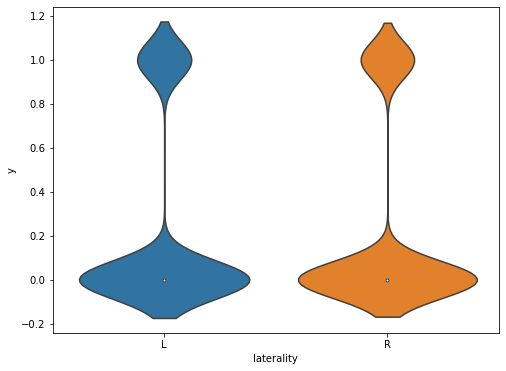


view_type -- Feature 
 | is not numeric | 2 unique values  | consider one-hot?
target percentages:  0    76.5
1    23.5
Name: y, dtype: float64
             view_type
view_type y           
CC        0       76.8
          1       23.2
MLO       0       76.0
          1       24.0


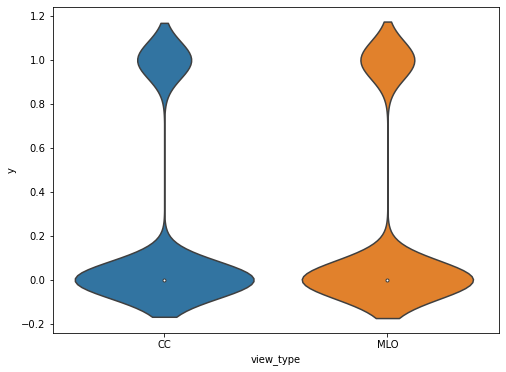


lat_sn_count -- Feature 
count    5914.00
mean        1.98
std         0.35
min         1.00
25%         2.00
50%         2.00
75%         2.00
max         5.00
Name: lat_sn_count, dtype: float64


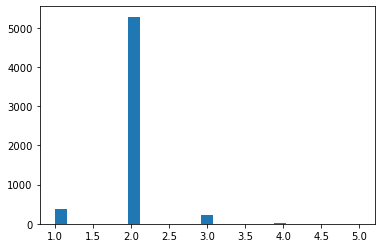

 | is numeric | 5 unique values  | consider one-hot? (ordinal?) 
target percentages:  0    76.5
1    23.5
Name: y, dtype: float64
                lat_sn_count
lat_sn_count y              
1            0          86.0
             1          14.0
2            0          76.0
             1          24.0
3            0          74.0
             1          26.0
4            0          50.0
             1          50.0
5            1         100.0


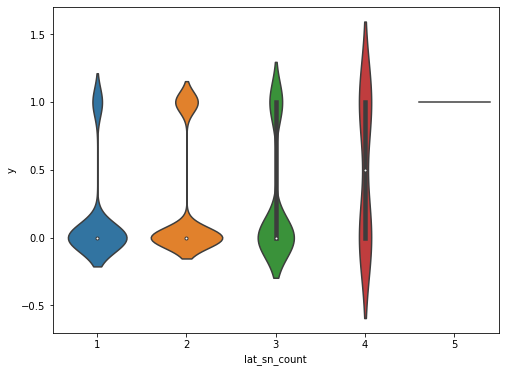


view_type_sn_count -- Feature 
count    5914.00
mean        1.96
std         0.38
min         1.00
25%         2.00
50%         2.00
75%         2.00
max         5.00
Name: view_type_sn_count, dtype: float64


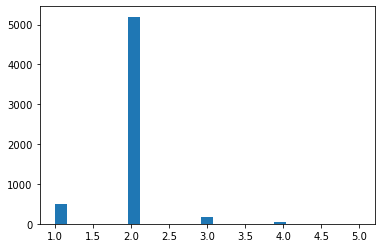

 | is numeric | 5 unique values  | consider one-hot? (ordinal?) 
target percentages:  0    76.5
1    23.5
Name: y, dtype: float64
                      view_type_sn_count
view_type_sn_count y                    
1                  0                91.1
                   1                 8.9
2                  0                75.4
                   1                24.6
3                  0                70.2
                   1                29.8
4                  0                66.7
                   1                33.3
5                  0                20.0
                   1                80.0


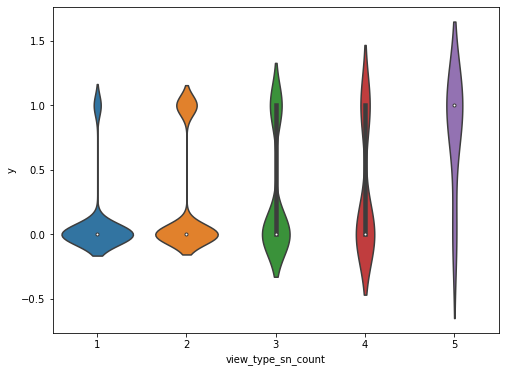

In [17]:
# basic description of all features
eda_utils.describe_features(df_all, target_column='y', is_target_categorical=True)

#### Notes
* Unbalanced data set (roughly 3 to 1 negative to positive) but not hugely unbalanced
* Split for each 'view' feature follows the same balance (roughly 3 to 1 negative to positive)
* yhat predictions are likely probabilities on the 0 to 1 range. Possible that yhat was trained on a much more skewed data set and that is influencing the probabilities to be much lower. Using a 0.5 classifier, yhat would not predict many positive samples
* For the lat_sn_count and view_type_sn_count, The most common occurence is 2. Since this is a created feature based on a not completely understood feature of study_num I should be careful about adding these features.
* The study_num counts should be looked into a bit more like what I did with lat_sn_count and view_type_sn_count

In [18]:
# following up on yhat
len(df_all[df_all['yhat'] >= 0.5])/len(df_all)

0.13256679066621577

In [19]:
# following up on study_num
df_all['study_num'].value_counts()

5259     8
3485     7
3721     6
11435    6
5489     6
        ..
12541    1
11749    1
3722     1
11712    1
11080    1
Name: study_num, Length: 1678, dtype: int64

#### Notes
* Count of study_num should become a feature as well
* Using a 0.5 predictor threshold, only ~1/8 yhat predict positive when the data has about 1/4 postives. This would be something I would like to follow up on with whoever created the data set
* I'm curious how the data set was curated. Like the study_num values that were included, is there any pattern in the difference between the study_num and the number of study_num included/excluded? This could bias the data set.

In [20]:
# creating features for count of number of tests done by study_num level
df_all_backup = df_all.copy() # storing here temporarily since I'm not the best with groupby and merges
df_temp = df_all.groupby(['study_num'])['row_num'].count().reset_index(name="sn_count")

# merge counts in
df_all_backup = df_all_backup.merge(df_temp, how="inner",on=['study_num'])
df_all_backup.head()

,row_num,study_num,view,y,yhat,laterality,view_type,lat_sn_count,view_type_sn_count,sn_count
0,0,8,LCC,0,0.000857,L,CC,1,2,3
1,2,8,RCC,1,0.525933,R,CC,2,2,3
2,1,8,RMLO,1,0.542956,R,MLO,2,1,3
3,3,10,RMLO,1,0.354297,R,MLO,2,1,3
4,5,10,RCC,1,0.070244,R,CC,2,2,3


In [21]:
df_all = df_all_backup.copy()

Target Column Counts and Distribution: 
0    4522
1    1392
Name: y, dtype: int64
0    76.5
1    23.5
Name: y, dtype: float64

sn_count -- Feature 
count    5914.00
mean        3.83
std         0.74
min         1.00
25%         4.00
50%         4.00
75%         4.00
max         8.00
Name: sn_count, dtype: float64


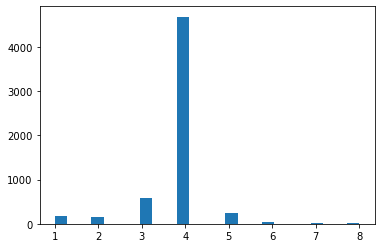

 | is numeric | 8 unique values  | consider one-hot? (ordinal?) 
target percentages:  0    76.5
1    23.5
Name: y, dtype: float64
            sn_count
sn_count y          
1        0     100.0
2        0      96.3
         1       3.7
3        0      77.6
         1      22.4
4        0      75.4
         1      24.6
5        0      66.7
         1      33.3
6        0      85.7
         1      14.3
7        0      28.6
         1      71.4
8        1     100.0


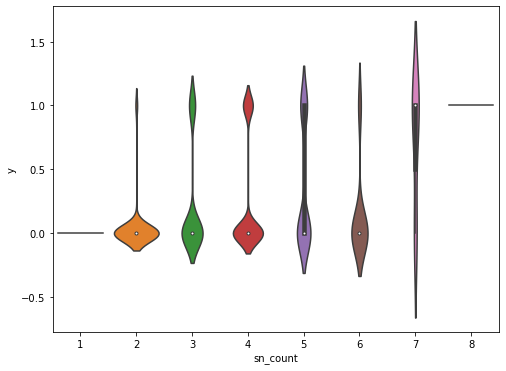


y -- Feature 
count    5914.00
mean        0.24
std         0.42
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: y, dtype: float64


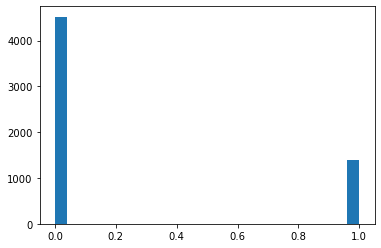

 | is numeric | 2 unique values  | consider one-hot? (ordinal?) 
target percentages:  0    76.5
1    23.5
Name: y, dtype: float64
         y
y y       
0 0  100.0
1 1  100.0


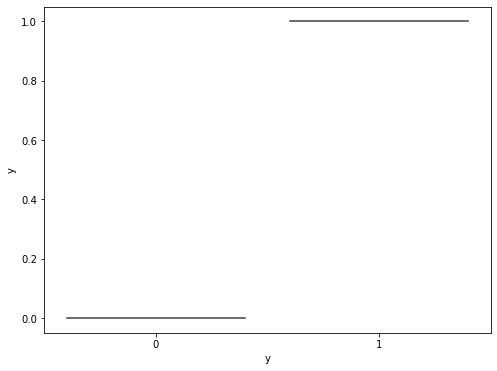

In [22]:
# rerunning the EDA above, only looking at the new sn_count feature
eda_utils.describe_features(df_all[['sn_count', 'y']], target_column='y', is_target_categorical=True)

In [23]:
df_all['sn_count'].value_counts()

4    4680
3     588
5     255
1     170
2     164
6      42
8       8
7       7
Name: sn_count, dtype: int64

In [24]:
# does more study number tests potentially indicate something
df_temp = df_all[df_all['sn_count'] > 4]
np.sum(df_temp['y'])/len(df_temp)

0.3333333333333333

#### Notes
* 4 for study_num count is the highest value (what you would expect if each study_num is a patient) 
* 33% postive rate (compared to 25%) case of study_number when there are more than 4 tests
* I would definitely follow up on study_num to get more details about it and which study_num was being selected
* Is there an obvious reason why the positivity rate is higher for more study_num tests being done? Ie follow up tests for something specific, probabilities increasing simply due to more trials, etc?

Simple plt.plot, looking for horizontal lines for repeated values or vertical lines for non shuffled
Train row_num


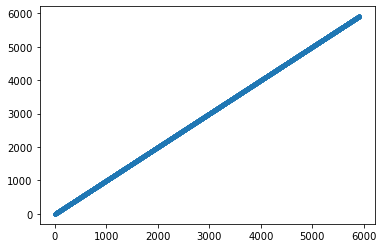

Train study_num


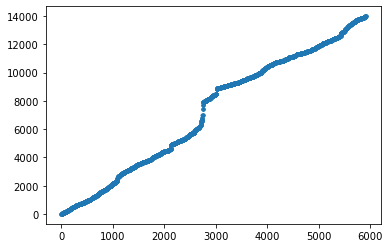

Train y


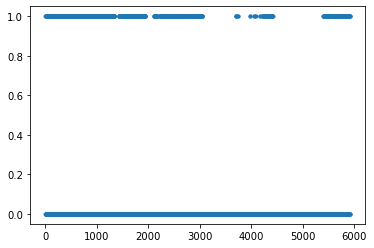

Train yhat


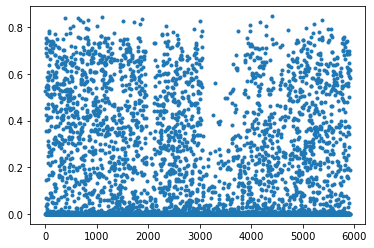

Train lat_sn_count


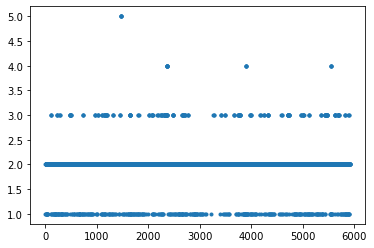

Train view_type_sn_count


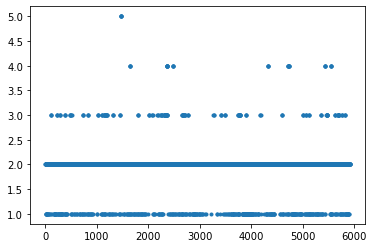

Train sn_count


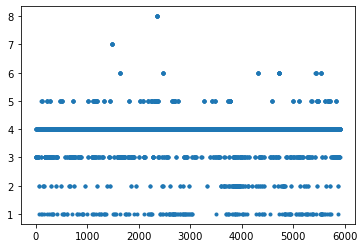

In [25]:
# simple index plots
# Simple plt.plot, looking for horizontal lines for repeated values or vertical lines for non shuffled
eda_utils.index_plots(df_all)

#### Notes
* The study_num value increase has a weird jump in it. Perhaps training or data collection changed in this timeframe? This would be worth looking into or perhaps analyzing the data on either side of the jump if more time.




Columns with least unique values: 
y                        2
laterality               2
view_type                2
view                     4
lat_sn_count             5
view_type_sn_count       5
sn_count                 8
study_num             1678
yhat                  5910
row_num               5914
dtype: int64
Histogram of unique values


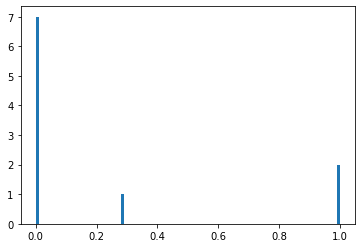

In [26]:
# check that each column has unique values
eda_utils.check_column_counts(df_all)

In [27]:
# check for unique rows
eda_utils.check_unique_rows(df_all, target_col='y')

Total Unique Values (Total rows 5914)
row_num               5914
study_num             1678
view                     4
y                        2
yhat                  5910
laterality               2
view_type                2
lat_sn_count             5
view_type_sn_count       5
sn_count                 8
dtype: int64
Rows with duplicated values (no target col): 0
Rows with duplicated values (including target col): 0
Empty DataFrame
Columns: [row_num, study_num, view, y, yhat, laterality, view_type, lat_sn_count, view_type_sn_count, sn_count]
Index: []


,row_num,study_num,view,y,yhat,laterality,view_type,lat_sn_count,view_type_sn_count,sn_count


In [28]:
# quick and dirty Random Forest to see the feature importance
from sklearn.ensemble import RandomForestClassifier

#categorical variables: view, laterality, view_type
df_oh_v = pd.get_dummies(df_all['view']) 
df_oh_l = pd.get_dummies(df_all['laterality'])
df_oh_vt = pd.get_dummies(df_all['view_type'])

df_temp = pd.concat([df_all, df_oh_v, df_oh_l, df_oh_vt], axis=1)
temp_y = df_all['y'].values

to_drop_cols = ['y', 'view', 'laterality', 'view_type']
df_temp = df_temp.drop(to_drop_cols,axis=1)
clf = RandomForestClassifier(max_depth=2, random_state=0, n_jobs=3)
clf.fit(df_temp, temp_y)

RandomForestClassifier(max_depth=2, n_jobs=3, random_state=0)

In [29]:
rf_feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = df_temp.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
rf_feature_importances

,importance
yhat,0.379730
study_num,0.239817
row_num,0.219690
sn_count,0.084788
view_type_sn_count,0.033634
lat_sn_count,0.026056
L,0.010462
RCC,0.001934
CC,0.001620
LMLO,0.000832


#### EDA Summary
* I have questions on study_num, data generation, and data curation that should be looked into
* I have created some features but I should be careful about potential increased dimensionality concerns with such a small data set
* I have concerns that row_num and possibly study_num have such high feature importance

In [30]:
# saving data frame
eda_file_out = "df_after_eda.csv"
df_all.to_csv(eda_file_out, index=False)

### Section 2: Data Preparation
* Basic plan is to: 
    * One hot the ordinal values (view, laterality, view type)
    * Scale the numeric values (row_num, the counts)
    * Make a new study_num column that is scaled (yes this is ordinal but I wonder if there is leaky feature in here due to the possible time nature or sequencing of how study_num is generated)
* Things I considered but dismissed to due time constraints or dimensionality worries, since I might have already created too many features:
    * Label encoding, mean encoding
    * Adding more two or more way interactions between features. I'm keeping the two way interaction 'view' but dropping view since I broke view into view_type and laterality might be preferred.
    

In [31]:
# check point
# notebook can be rerun from here

# dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
pd.options.display.max_columns = None
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook

In [32]:
df_all_in = pd.read_csv("df_after_eda.csv")
df_all_in.head()

,row_num,study_num,view,y,yhat,laterality,view_type,lat_sn_count,view_type_sn_count,sn_count
0,0,8,LCC,0,0.000857,L,CC,1,2,3
1,2,8,RCC,1,0.525933,R,CC,2,2,3
2,1,8,RMLO,1,0.542956,R,MLO,2,1,3
3,3,10,RMLO,1,0.354297,R,MLO,2,1,3
4,5,10,RCC,1,0.070244,R,CC,2,2,3


In [33]:
# create study_num scaled column
df_all = df_all_in.copy()
df_all['study_num_scaled'] = df_all['study_num']

#scale numerical values
scale_columns = ['lat_sn_count', 'view_type_sn_count', 'sn_count', 'study_num_scaled']
scaler = MinMaxScaler()

df_all[scale_columns] = scaler.fit_transform(df_all[scale_columns])

In [34]:
# handle categorical variables
len(df_all['study_num'].drop_duplicates())

1678

In [35]:
# too many categorical variables to one hot study_num. I also don't think label or mean encoding makes sense in this case.

In [36]:
#categorical variables: view, laterality, view_type
df_oh_v = pd.get_dummies(df_all['view']) 
df_oh_l = pd.get_dummies(df_all['laterality'])
df_oh_vt = pd.get_dummies(df_all['view_type'])
df_all_oh = pd.concat([df_all, df_oh_v, df_oh_l, df_oh_vt], axis=1)

df_all_oh.shape

(5914, 19)

In [37]:
# checking transformation came out okay
df_all_oh.head()

,row_num,study_num,view,y,yhat,laterality,view_type,lat_sn_count,view_type_sn_count,sn_count,study_num_scaled,LCC,LMLO,RCC,RMLO,L,R,CC,MLO
0,0,8,LCC,0,0.000857,L,CC,0.00,0.25,0.285714,0.000000,1,0,0,0,1,0,1,0
1,2,8,RCC,1,0.525933,R,CC,0.25,0.25,0.285714,0.000000,0,0,1,0,0,1,1,0
2,1,8,RMLO,1,0.542956,R,MLO,0.25,0.00,0.285714,0.000000,0,0,0,1,0,1,0,1
3,3,10,RMLO,1,0.354297,R,MLO,0.25,0.00,0.285714,0.000143,0,0,0,1,0,1,0,1
4,5,10,RCC,1,0.070244,R,CC,0.25,0.25,0.285714,0.000143,0,0,1,0,0,1,1,0


In [38]:
df_all_oh.describe()

,row_num,study_num,y,yhat,lat_sn_count,view_type_sn_count,sn_count,study_num_scaled,LCC,LMLO,RCC,RMLO,L,R,CC,MLO
count,5914.000000,5914.000000,5914.000000,5914.000000,5914.000000,5914.000000,5914.000000,5914.000000,5914.000000,5914.000000,5914.000000,5914.000000,5914.000000,5914.000000,5914.000000,5914.000000
mean,2956.500000,7248.516064,0.235374,0.153561,0.245773,0.239601,0.403594,0.517957,0.262766,0.214068,0.265641,0.257525,0.476835,0.523165,0.528407,0.471593
std,1707.369077,4264.464809,0.424268,0.229188,0.087013,0.094996,0.105211,0.305062,0.440174,0.410209,0.441711,0.437308,0.499505,0.499505,0.499235,0.499235
min,0.000000,8.000000,0.000000,0.000168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1478.250000,3486.500000,0.000000,0.000964,0.250000,0.250000,0.428571,0.248838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2956.500000,8385.000000,0.000000,0.002955,0.250000,0.250000,0.428571,0.599256,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,4434.750000,11077.750000,0.000000,0.279555,0.250000,0.250000,0.428571,0.791884,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,5913.000000,13987.000000,1.000000,0.847084,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
# saving data frame
df_all_oh = df_all_oh.sort_values(by="row_num")
eda_file_out_2 = "df_after_pp.csv"
df_all_oh.to_csv(eda_file_out_2, index=False)

### Section 3: Feature Selection, Models, and Hyperparameter Tuning
* For models I decided on Logistic Regression,  gradient boosting (Light GBM), and Random Forests. All three models are fast, well-established and offer explanability in their feature importances.
* I decided not to try a Neural Net, model stacking/blending/ensemble due to the small amount of data. If it was a larger data set then I would try the NN and some ensembling. 

In [40]:
# check point, model can be rerun from here
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
pd.options.display.max_columns = None
random_state = 42

In [41]:
# drop unnecessary columns, split into train and test
df_all_in = pd.read_csv("df_after_pp.csv")
df_all_in.head()

,row_num,study_num,view,y,yhat,laterality,view_type,lat_sn_count,view_type_sn_count,sn_count,study_num_scaled,LCC,LMLO,RCC,RMLO,L,R,CC,MLO
0,0,8,LCC,0,0.000857,L,CC,0.00,0.25,0.285714,0.000000,1,0,0,0,1,0,1,0
1,1,8,RMLO,1,0.542956,R,MLO,0.25,0.00,0.285714,0.000000,0,0,0,1,0,1,0,1
2,2,8,RCC,1,0.525933,R,CC,0.25,0.25,0.285714,0.000000,0,0,1,0,0,1,1,0
3,3,10,RMLO,1,0.354297,R,MLO,0.25,0.00,0.285714,0.000143,0,0,0,1,0,1,0,1
4,4,10,LCC,0,0.000446,L,CC,0.00,0.25,0.285714,0.000143,1,0,0,0,1,0,1,0


#### Train-Test Split and Cross Validation
* Separate the data into train and test splits
* Set up cross validation split and then use grid search of the hyperparameters to tune
* I realize that hyperparameter search can be done better. Like random search is better than grid search and Bayesian approaches can be better than both. I've been using wandb.com for hyperparameter search in other projects and given more time would take a similar approach to this problem.

In [42]:
# split into train and test set
df_temp = df_all_in.copy()

# drop columns that have been one-hotted
to_drop_columns = ['view', 'laterality', 'view_type', 'y', 'study_num']
temp_y = df_temp.y.values
df_temp = df_temp.drop(to_drop_columns,axis=1)
X_train, X_test, y_train, y_test = train_test_split( df_temp, temp_y, test_size=0.2, random_state=random_state, stratify=temp_y)

In [43]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4731, 14) (1183, 14) (4731,) (1183,)


#### 3.1 Gradient Boosting with LightGBM

In [44]:
cv_split = KFold(n_splits=4, shuffle=True, random_state=random_state).split(X=X_train, y=y_train)

param_grid = {
    'max_depth': [3, 7],
    #'bagging_fraction':[0.6, 0.8, 1.0],
    #'feature_fraction':[0.6, 0.8, 1.0],
    'num_iterations':[20, 50],
    'learning_rate':[0.03, 0.1],
    #'lambda_l1':[0.0, 0.2],
    # 'lambda_l2':[0.0, 0.1],
    'min_data_in_leaf':[10, 20]
    }

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', metric='auc', seed=random_state)

gs = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=cv_split, n_jobs=-1)
lgb_gs = gs.fit(X=X_train, y=y_train)
lgb_model = lgb_gs.best_estimator_
print(lgb_model)

LGBMClassifier(max_depth=7, metric='auc', min_data_in_leaf=10,
               num_iterations=20, objective='binary', seed=42)


C:\Users\james\Anaconda3\envs\csc723\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [45]:
# seeing predictions
pred_lgb_test = lgb_model.predict(X_test.values)
pred_lgb_train = lgb_model.predict(X_train.values)

lgb_test_acc = accuracy_score(y_test, pred_lgb_test)
print('Test Accuracy for LightGBM is %f' % lgb_test_acc)

lgb_train_acc = accuracy_score(y_train, pred_lgb_train)
print('Train Accuracy for LightGBM is %f' % lgb_train_acc)

auc_lgb_test = lgb_model.predict_proba(X_test.values)[:,1]
auc_lgb_train = lgb_model.predict_proba(X_train.values)[:,1]

lgb_test_auc = roc_auc_score(y_test, auc_lgb_test)
print('Test AUC for LightGBM is %f' % lgb_test_auc)

lgb_train_auc = roc_auc_score(y_train, auc_lgb_train)
print('Train AUC for LightGBM is %f' % lgb_train_auc)

Test Accuracy for LightGBM is 0.879966
Train Accuracy for LightGBM is 0.902980
Test AUC for LightGBM is 0.923916
Train AUC for LightGBM is 0.949988


In [46]:
lgb_feature_importances = pd.DataFrame(lgb_model.feature_importances_,
                                    index=X_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
lgb_feature_importances

,importance
row_num,204
yhat,155
study_num_scaled,110
sn_count,55
L,18
lat_sn_count,17
view_type_sn_count,14
LCC,10
R,7
RCC,6


#### Feature selection
* Simple example of feature selection to demonstrate I know to consider feature selection
* However based on the high performance of row_num and study_num_scaled I'd want to consult on how the data was generated before doing feature selection

In [47]:
# automated feature selection using SelectFromModel
lgb_select_model = SelectFromModel(lgb_model, prefit=True)
X_train_lgb_selected = lgb_select_model.transform(X_train)
X_test_lgb_selected = lgb_select_model.transform(X_test)
print("Shape of full data",np.shape(X_train)  )
print("Shape of selected data",np.shape(X_train_lgb_selected)  )

Shape of full data (4731, 14)
Shape of selected data (4731, 4)


C:\Users\james\Anaconda3\envs\csc723\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\james\Anaconda3\envs\csc723\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [48]:
# running hyperparameter tuning with selected features
cv_split = KFold(n_splits=4, shuffle=True, random_state=random_state).split(X=X_train, y=y_train)

param_grid = {
    'max_depth': [3, 7],
    #'bagging_fraction':[0.6, 0.8, 1.0],
    #'feature_fraction':[0.6, 0.8, 1.0],
    'num_iterations':[20, 50],
    'learning_rate':[0.03, 0.1],
    #'lambda_l1':[0.0, 0.2],
    # 'lambda_l2':[0.0, 0.1],
    'min_data_in_leaf':[10, 20]
    }

lgb_estimator_sf = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', metric='auc', seed=random_state)

gs_sf = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=cv_split, n_jobs=-1)
lgb_gs_sf = gs_sf.fit(X=X_train_lgb_selected, y=y_train)
lgb_model_sf = lgb_gs_sf.best_estimator_
print(lgb_model_sf)

LGBMClassifier(max_depth=7, metric='auc', min_data_in_leaf=10,
               num_iterations=50, objective='binary', seed=42)


C:\Users\james\Anaconda3\envs\csc723\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [49]:
# accuracy and AUC scores
pred_lgb_test_sf = lgb_model_sf.predict(X_test_lgb_selected)
pred_lgb_train_sf = lgb_model_sf.predict(X_train_lgb_selected)

lgb_test_acc_sf = accuracy_score(y_test, pred_lgb_test_sf)
print('Test Accuracy for LightGBM is %f' % lgb_test_acc_sf)

lgb_train_acc_sf = accuracy_score(y_train, pred_lgb_train_sf)
print('Train Accuracy for LightGBM is %f' % lgb_train_acc_sf)

auc_lgb_test_sf = lgb_model_sf.predict_proba(X_test_lgb_selected)[:,1]
auc_lgb_train_sf = lgb_model_sf.predict_proba(X_train_lgb_selected)[:,1]

lgb_test_auc_sf = roc_auc_score(y_test, auc_lgb_test_sf)
print('Test AUC for LightGBM is %f' % lgb_test_auc_sf)

lgb_train_auc_sf = roc_auc_score(y_train, auc_lgb_train_sf)
print('Train AUC for LightGBM is %f' % lgb_train_auc_sf)

Test Accuracy for LightGBM is 0.879966
Train Accuracy for LightGBM is 0.908687
Test AUC for LightGBM is 0.925555
Train AUC for LightGBM is 0.964187


In [50]:
lgb_feature_importances_sf = pd.DataFrame(lgb_model_sf.feature_importances_,
                                    index=X_train.columns[lgb_select_model.get_support()],
                                    columns=['importance']).sort_values('importance',  ascending=False)
lgb_feature_importances_sf

,importance
row_num,574
yhat,477
study_num_scaled,268
sn_count,164


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

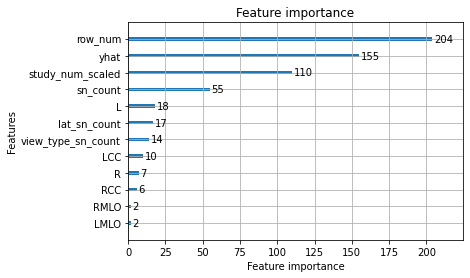

In [51]:
lgb.plot_importance(lgb_model)

#### 3.2 Random Forest

In [52]:
# Random Forest Model
cv_split = KFold(n_splits=4, shuffle=True, random_state=random_state).split(X=X_train, y=y_train)

param_grid = {
    'n_estimators': [10, 50],
    'max_depth':[3, 10],
    'max_features':[0.8, None],
    'min_samples_leaf':[5, 10]
    }

rf_estimator = RandomForestClassifier( random_state=0, n_jobs=-1)

gs = GridSearchCV(estimator=rf_estimator, param_grid=param_grid, cv=cv_split, n_jobs=-1)
rf_gs = gs.fit(X=X_train, y=y_train)
rf_model = rf_gs.best_estimator_
print(rf_model)

RandomForestClassifier(max_depth=10, max_features=0.8, min_samples_leaf=10,
                       n_estimators=50, n_jobs=-1, random_state=0)


In [53]:
# accuracy and AUC scores
pred_rf_test = rf_model.predict(X_test.values)
pred_rf_train = rf_model.predict(X_train.values)

rf_test_acc = accuracy_score(y_test, pred_rf_test )
print('Test Accuracy for Random Forest is %f' % rf_test_acc)

rf_train_acc = accuracy_score(y_train, pred_rf_train)
print('Train Accuracy for Random Forest is %f' % rf_train_acc)

auc_rf_test = rf_model.predict_proba(X_test)[:,1]
auc_rf_train = rf_model.predict_proba(X_train)[:,1]

rf_test_auc = roc_auc_score(y_test, auc_rf_test)
print('Test AUC for Random Forest is %f' % rf_test_auc )

rf_train_auc = roc_auc_score(y_train, auc_rf_train)
print('Train AUC for Random Forest is %f' % rf_train_auc)

Test Accuracy for Random Forest is 0.880811
Train Accuracy for Random Forest is 0.905305
Test AUC for Random Forest is 0.923433
Train AUC for Random Forest is 0.962866


C:\Users\james\Anaconda3\envs\csc723\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\james\Anaconda3\envs\csc723\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [54]:
# Importance of various features in Random Forest Model
rf_feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
rf_feature_importances

,importance
yhat,0.538904
row_num,0.213642
study_num_scaled,0.188826
sn_count,0.029868
L,0.004417
lat_sn_count,0.004293
view_type_sn_count,0.004277
R,0.003699
RCC,0.003153
LCC,0.002944


#### 3.3 Logistic Regression

In [55]:
# Logistic Regression Model
cv_split = KFold(n_splits=4, shuffle=True, random_state=42).split(X=X_train, y=y_train)

param_grid = {
    'C':[0.1, 0.3, 1.]
    }

lr_estimator = LogisticRegression(n_jobs=-1, random_state=0)

gs = GridSearchCV(estimator=lr_estimator, param_grid=param_grid, cv=cv_split, n_jobs=-1)
lr_gs = gs.fit(X=X_train, y=y_train)
lr_model = lr_gs.best_estimator_
print(lr_model)

LogisticRegression(C=0.3, n_jobs=-1, random_state=0)


In [56]:
# accuracy and AUC scores
pred_lr_test = lr_model.predict(X_test.values)
pred_lr_train = lr_model.predict(X_train.values)

lr_test_acc = accuracy_score(y_test, pred_lr_test )
print('Test Accuracy for Logistic Regression is %f' % lr_test_acc)

lr_train_acc = accuracy_score(y_train, pred_lr_train)
print('Train Accuracy for Logistic Regression is %f' % lr_train_acc)

auc_lr_test = lr_model.predict_proba(X_test)[:,1]
auc_lr_train = lr_model.predict_proba(X_train)[:,1]

lr_test_auc = roc_auc_score(y_test, auc_lr_test)
print('Test AUC for Logistic Regression is %f' % lr_test_auc )

lr_train_auc = roc_auc_score(y_train, auc_lr_train)
print('Train AUC for Logistic Regression is %f' % lr_train_auc)

Test Accuracy for Logistic Regression is 0.840237
Train Accuracy for Logistic Regression is 0.850560
Test AUC for Logistic Regression is 0.845622
Train AUC for Logistic Regression is 0.870239


C:\Users\james\Anaconda3\envs\csc723\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\james\Anaconda3\envs\csc723\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


#### Section 4: Ensembles
* NA

#### Section 5: Results and Conclusion
* Light GBM AUC (Test -- Train): 0.92 -- 0.96
* Random Forest AUC (Test -- Train): 0.92 -- 0.97
* Logistic Regression AUC (Test -- Train): 0.86 -- 0.86
* Confusion Matricies and AUC plots are presented using the Light GBM model

In [57]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

print("LightGBM Model Results")
print("---")
print("Test Confusion Matrix")
print(metrics.confusion_matrix(y_test, pred_lgb_test))
print("Test Classification Report")
print(metrics.classification_report(y_test, pred_lgb_test, digits=3))

LightGBM Model Results
---
Test Confusion Matrix
[[872  33]
 [109 169]]
Test Classification Report
              precision    recall  f1-score   support

           0      0.889     0.964     0.925       905
           1      0.837     0.608     0.704       278

    accuracy                          0.880      1183
   macro avg      0.863     0.786     0.814      1183
weighted avg      0.877     0.880     0.873      1183



In [58]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

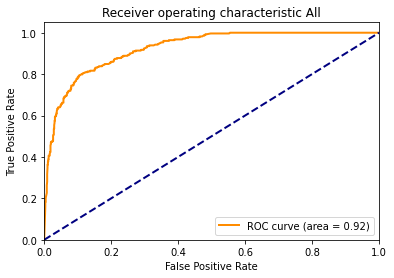

In [59]:
# ROC score for LGB Model 
fpr, tpr, _ = roc_curve(y_test, lgb_model.predict_proba(X_test.values)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic All")
plt.legend(loc="lower right")
plt.show()

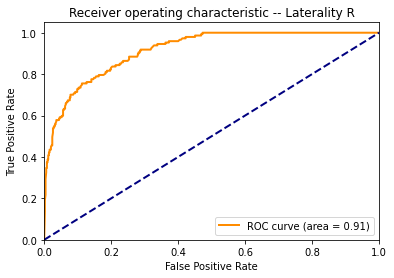

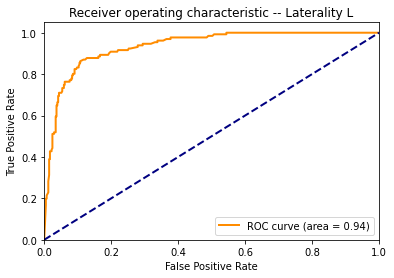

In [60]:
# ROC score for LGB Model by lateral
lgb_predict_proba_true = lgb_model.predict_proba(X_test.values)[:,1]
X_test_R = lgb_predict_proba_true[X_test["R"] == 1]
y_test_R = y_test[X_test["R"] == 1]
X_test_L = lgb_predict_proba_true[X_test["L"] == 1]
y_test_L = y_test[X_test["L"] == 1]

fpr_R, tpr_R, _ = roc_curve(y_test_R, X_test_R)
roc_auc_R = auc(fpr_R, tpr_R)

fpr_L, tpr_L, _ = roc_curve(y_test_L, X_test_L)
roc_auc_L = auc(fpr_L, tpr_L)

plt.figure()
lw = 2
plt.plot(
    fpr_R,
    tpr_R,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc_R,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic -- Laterality R")
plt.legend(loc="lower right")

plt.figure()
lw = 2
plt.plot(
    fpr_L,
    tpr_L,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc_L,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic -- Laterality L")
plt.legend(loc="lower right")
plt.show()

##### Conclusion

I am hesitant to draw a conclusion since I have major questions with the features and how the data was collected. I am concerned about why row number and study_num_scaled would have such importance. After research and deciding how to address those features, I would like to rerun the analysis using what we would expect to be the features and come up with a proper conclusion. I would also take the opportunity at that time to improve hyperparameter tuning and feature selection parts.